In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.applications import DenseNet121,MobileNetV2,vgg19
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomZoom, Rescaling
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
root_train = '/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/train/'
root_test = '/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/'

labels = ['normal', 'pneumonia','covid']

def check_ims_in_folder(labels):
    '''returns tuples of images in each folder'''
    train_ims_normal = os.listdir(root_train+labels[0]+'/')
    train_ims_pneumonia = os.listdir(root_train+labels[1]+'/')
    train_ims_covid = os.listdir(root_train+labels[2]+'/')
    
    
    test_ims_normal = os.listdir(root_test+labels[0]+'/')
    test_ims_pneumonia = os.listdir(root_test+labels[1]+'/')
    test_ims_covid = os.listdir(root_test+labels[2]+'/')
    
    return (train_ims_normal, train_ims_pneumonia,train_ims_covid), (test_ims_normal, test_ims_pneumonia,test_ims_covid)

[0.15 1.15 2.15 3.15 4.15 5.15]


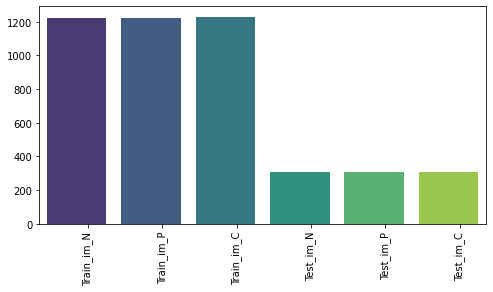

train_im_N:  1220
train_im_P:  1220
train_im_C:  1230
test_im_N:  305
test_im_P:  305
test_im_C:  305


In [ ]:
(train_im_n, train_im_p, train_im_c), (test_im_n, test_im_p, test_im_c) = check_ims_in_folder(labels)


index = np.arange(6) + 0.15
print (index)
labels_bar = ['Train_im_N', 'Train_im_P', 'Train_im_C', 'Test_im_N', 'Test_im_P','Test_im_C']

fig=plt.figure(figsize=(8, 4))
sns.barplot(x=index, y=[len(train_im_n), len(train_im_p), len(train_im_c), len(test_im_n), len(test_im_p),len(test_im_c)], palette="viridis")
plt.xticks(index, labels_bar, rotation='vertical')
plt.show()

print ('train_im_N: ', len(train_im_n))
print ('train_im_P: ', len(train_im_p))
print ('train_im_C: ', len(train_im_c))
print ('test_im_N: ', len(test_im_n))
print ('test_im_P: ', len(test_im_p))
print ('test_im_C: ', len(test_im_c))

In [ ]:
tot_normal_train = len(train_im_n) + len(test_im_n) 
tot_pneumonia_train = len(train_im_p) + len(test_im_p)
tot_covid_train = len(train_im_c) + len(test_im_c) 
print ('total normal xray images: ', tot_normal_train)
print ('total pneumonia xray images: ', tot_pneumonia_train)
print ('total covid xray images: ', tot_covid_train)

total normal xray images:  1525
total pneumonia xray images:  1525
total covid xray images:  1535


In [ ]:
def check_im_size(folder, labels):
    im_shape_x_lists_n = []
    im_shape_x_lists_p = []
    im_shape_x_lists_c = []
    im_shape_y_lists_n = []
    im_shape_y_lists_p = []
    im_shape_y_lists_c = []

    if folder=='train':
        path = root_train
        normal = train_im_n
        pneumonia = train_im_p
        covid = train_im_c
    else:
        path = root_test
        normal = test_im_n
        pneumonia = test_im_p
        covid = test_im_c
    for i, img in enumerate(normal):
        sample = os.path.join(path+labels[0]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_n.append(w)
        im_shape_y_lists_n.append(h)
    for i, img in enumerate(pneumonia):
        sample = os.path.join(path+labels[1]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_p.append(w)
        im_shape_y_lists_p.append(h)
    for i, img in enumerate(covid):
        sample = os.path.join(path+labels[2]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_c.append(w)
        im_shape_y_lists_c.append(h)
        
    return im_shape_x_lists_n, im_shape_y_lists_n, im_shape_x_lists_p, im_shape_y_lists_p,im_shape_x_lists_c,im_shape_y_lists_c

In [ ]:
im_shape_train_x_n, im_shape_train_y_n, im_shape_train_x_p, im_shape_train_y_p,im_shape_train_x_c,im_shape_train_y_c = check_im_size('train', labels)
im_shape_test_x_n, im_shape_test_y_n, im_shape_test_x_p, im_shape_test_y_p,im_shape_test_x_c, im_shape_test_y_c= check_im_size('test', labels)  

{1024} {1024}


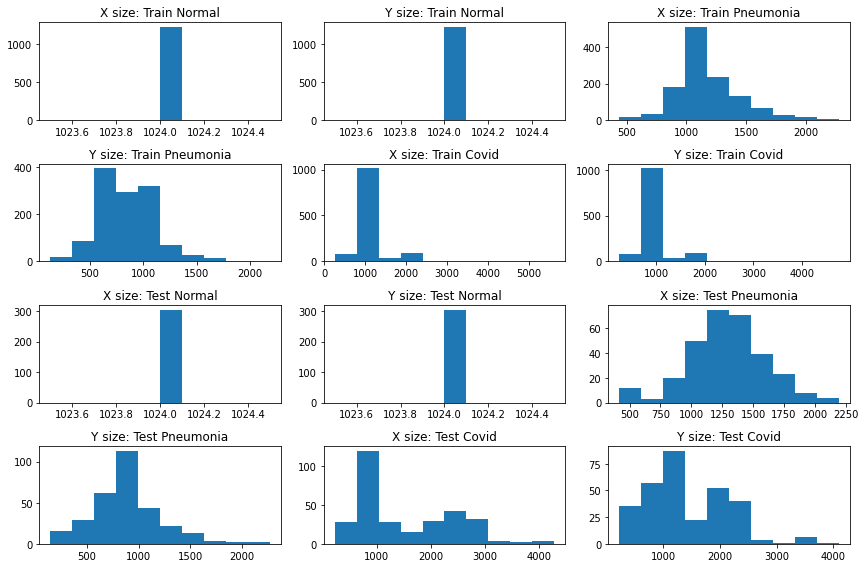

In [ ]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(431)
plt.hist(im_shape_train_x_n)
plt.title('X size: Train Normal')
fig.add_subplot(432)
plt.hist(im_shape_train_y_n)
plt.title('Y size: Train Normal')
fig.add_subplot(433)
plt.hist(im_shape_train_x_p)
plt.title('X size: Train Pneumonia')
fig.add_subplot(434)
plt.hist(im_shape_train_y_p)
plt.title('Y size: Train Pneumonia')
fig.add_subplot(435)
plt.hist(im_shape_train_x_c)
plt.title('X size: Train Covid')
fig.add_subplot(436)
plt.hist(im_shape_train_y_c)
plt.title('Y size: Train Covid')
fig.add_subplot(437)
plt.hist(im_shape_test_x_n)
plt.title('X size: Test Normal')
fig.add_subplot(438)
plt.hist(im_shape_test_y_n)
plt.title('Y size: Test Normal')
fig.add_subplot(439)
plt.hist(im_shape_test_x_p)
plt.title('X size: Test Pneumonia')
fig.add_subplot(4,3, 10)
plt.hist(im_shape_test_y_p)
plt.title('Y size: Test Pneumonia')
fig.add_subplot(4,3, 11)
plt.hist(im_shape_test_x_c)
plt.title('X size: Test Covid')
fig.add_subplot(4,3, 12)
plt.hist(im_shape_test_y_c)
plt.title('Y size: Test Covid')
plt.tight_layout()
print (set(im_shape_train_x_n), set(im_shape_train_y_n))

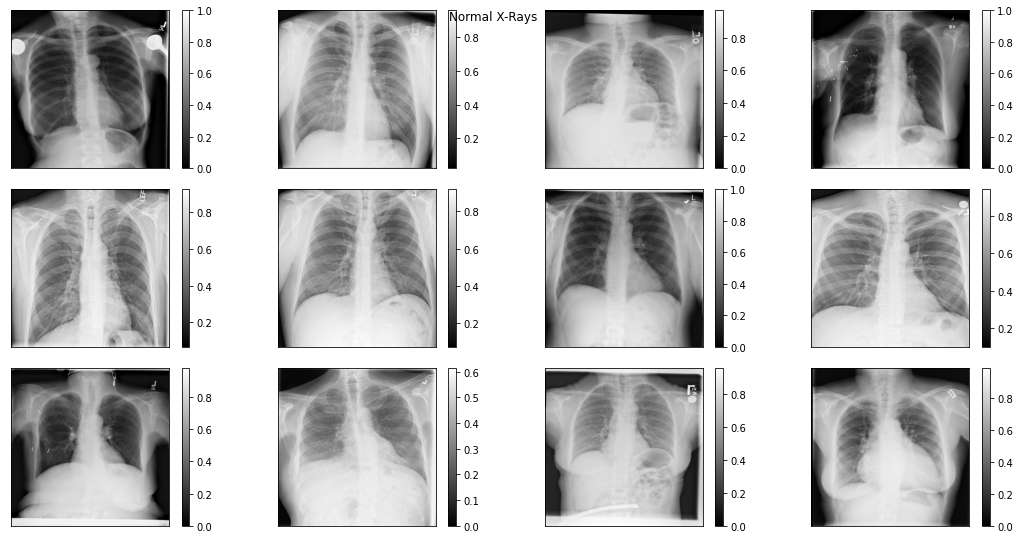

check shape of an example image:  (1024, 1024)


In [ ]:
import os, time, random
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_n_selected = random.sample(train_im_n, 12)
for i, img in enumerate(train_im_n_selected):
    sample = os.path.join(root_train +labels[0]+'/', img) 
    sample_img = Image.open(sample)   
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    ax = fig.add_subplot(int(npics/3) , 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    plt.colorbar()
    count +=1
fig.suptitle('Normal X-Rays')
plt.tight_layout()
plt.show()

print ('check shape of an example image: ', sample_img.shape,)

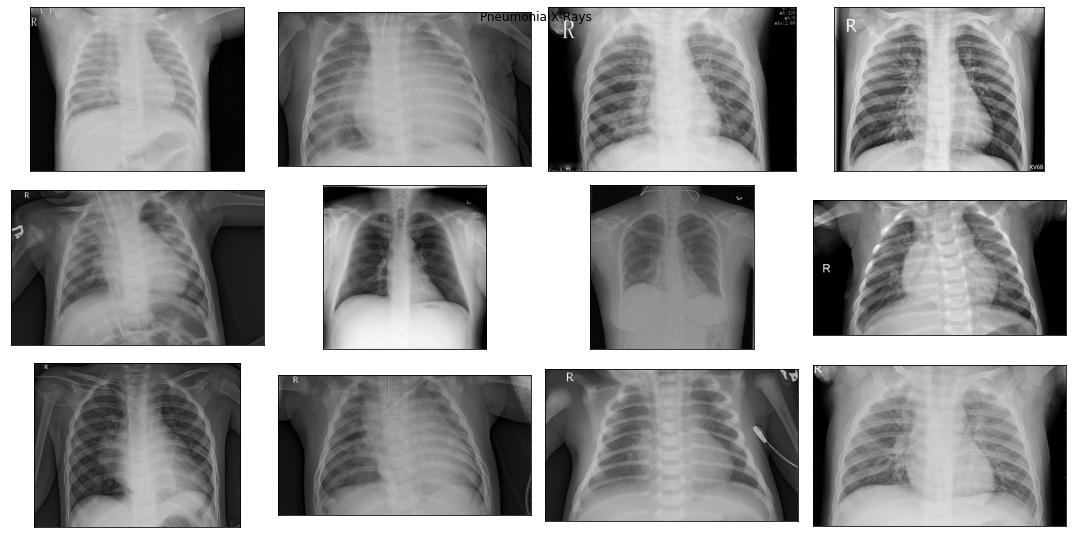

In [ ]:
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_p_selected = random.sample(train_im_p, 12)
for i, img in enumerate(train_im_p_selected):
    sample = os.path.join(root_train +labels[1]+'/', img) 
    sample_img = Image.open(sample)   
    ax = fig.add_subplot(int(npics/3), 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    count +=1
fig.suptitle('Pneumonia X-Rays')
plt.tight_layout()
plt.show()

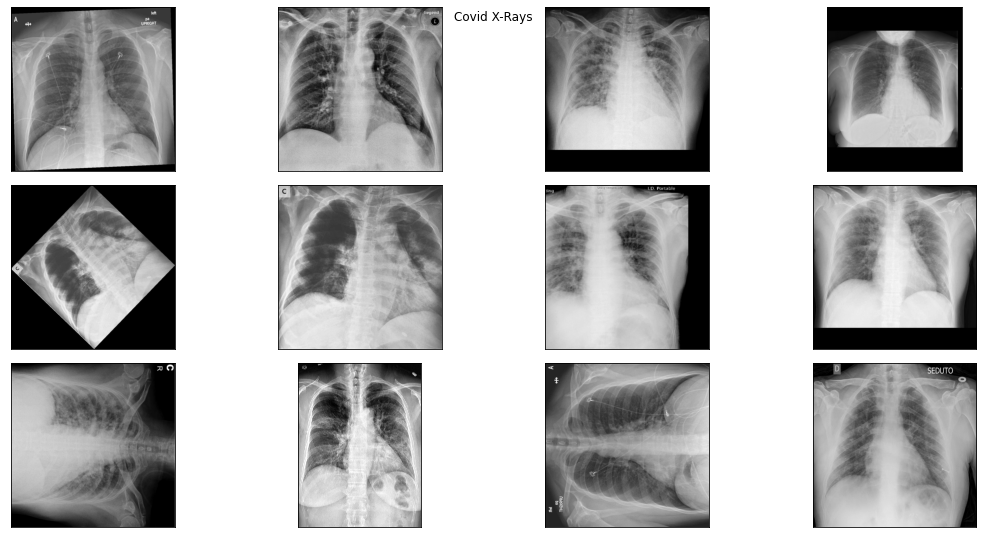

In [ ]:
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_c_selected = random.sample(train_im_c, 12)
for i, img in enumerate(train_im_c_selected):
    sample = os.path.join(root_train +labels[2]+'/', img) 
    sample_img = Image.open(sample)   
    ax = fig.add_subplot(int(npics/3), 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    count +=1
fig.suptitle('Covid X-Rays')
plt.tight_layout()
plt.show()

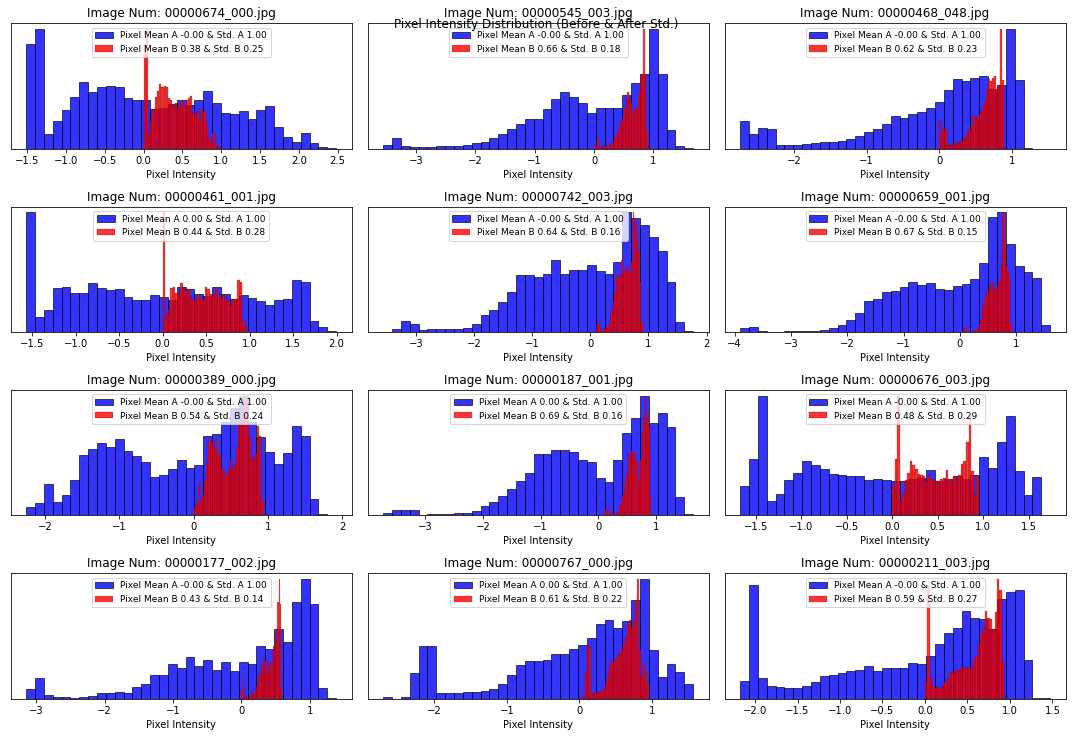

In [ ]:
fig = plt.figure(figsize=(15, 15))
count=1
for i, img in enumerate(train_im_n_selected):
    sample_one = os.path.join(root_train +labels[0]+'/', img)
    sample_img = Image.open(sample_one)   
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    sample_img_mean = np.mean(sample_img)
    sample_img_std = np.std(sample_img)
    new_sample_img = (sample_img - sample_img_mean)/sample_img_std
    ax = fig.add_subplot(int(npics/2) , 3, count, yticks=[])
    sns.histplot(new_sample_img.ravel(), 
             label=f'Pixel Mean A {np.mean(new_sample_img):.2f} & Std. A {np.std(new_sample_img):.2f}', kde=False, color='blue', bins=35, alpha=0.8)
    sns.histplot(sample_img.ravel(), 
             label=f'Pixel Mean B {np.mean(sample_img):.2f} & Std. B {np.std(sample_img):.2f}', kde=False, color='red', bins=35, alpha=0.8)
    plt.legend(loc='upper center', fontsize=9)
    plt.title('Image Num: %s'% (img))
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixels in Image')
    count +=1
fig.suptitle('Pixel Intensity Distribution (Before & After Std.)')
plt.tight_layout()
plt.show()

In [ ]:
#### define a function that will be added as lambda layer later
def standardize_layer(tensor):
    tensor_mean = tf.math.reduce_mean(tensor)
    tensor_std = tf.math.reduce_std(tensor)
    new_tensor = (tensor-tensor_mean)/tensor_std
    return new_tensor

In [ ]:
target_size = (300, 300)

input_shape = (300, 300, 1)

batch_size = 32


print("Training Dataset.....")
train_dir = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/train/', 
                                                                image_size=target_size, 
                                                                batch_size=batch_size,
                                                                shuffle=True,
                                                                color_mode='grayscale',
                                                                label_mode='categorical',
                                                                validation_split=0.3,
                                                                subset='training',
                                                                seed = 1337)



print("Val Dataset....")
val_dir = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/train/', 
                                                              image_size=target_size, 
                                                              batch_size=batch_size,
                                                              color_mode='grayscale',
                                                              label_mode='categorical',
                                                              validation_split=0.3,
                                                              subset='validation',
                                                              seed = 1337)

print("Test Datast...")
test_dir = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/', 
                                                               image_size=target_size, 
                                                               batch_size=batch_size, 
                                                               color_mode='grayscale',
                                                               label_mode='categorical')

Training Dataset.....
Found 3670 files belonging to 3 classes.
Using 2569 files for training.
Val Dataset....
Found 3670 files belonging to 3 classes.
Using 1101 files for validation.
Test Datast...
Found 915 files belonging to 3 classes.


In [ ]:
num_elements = tf.data.experimental.cardinality(train_dir).numpy()
print (num_elements)
num_elements_val = tf.data.experimental.cardinality(val_dir).numpy()
print (num_elements_val)

81
35


In [ ]:
class_names = train_dir.class_names
print(class_names)

['covid', 'normal', 'pneumonia']


In [ ]:
new_train_ds = train_dir.concatenate(val_dir)

print (new_train_ds, train_dir)

train_size = int(0.8 * 59) # 83 is the elements in dataset (train + valid)
val_size = int(0.2 * 59)
    
train_ds = new_train_ds.take(train_size)
val_ds = new_train_ds.skip(train_size).take(val_size)


#### check the dataset size back again 
num_elements_train = tf.data.experimental.cardinality(train_ds).numpy()
print (num_elements_train)
num_elements_val_ds = tf.data.experimental.cardinality(val_ds).numpy()
print (num_elements_val_ds)

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))> <BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
47
11


(32, 300, 300, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 3)


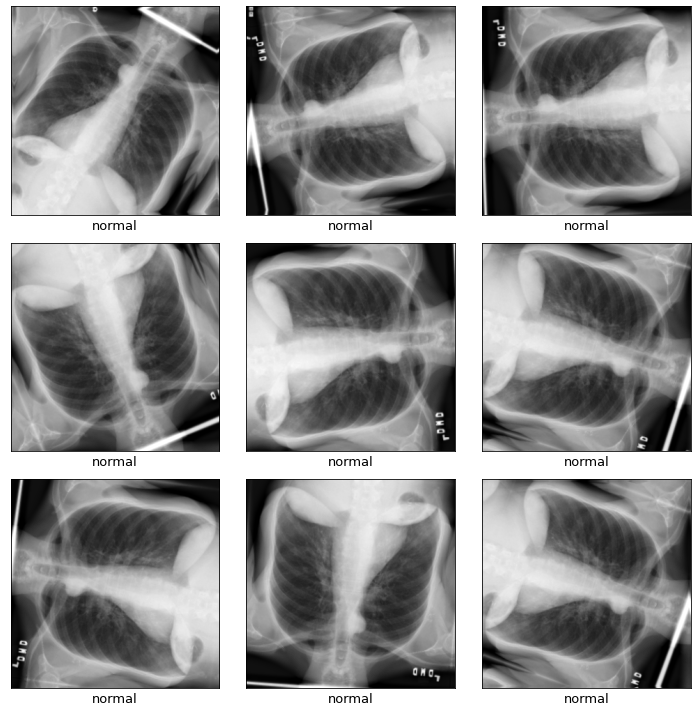

(32, 300, 300, 1) (300, 300, 1)


In [ ]:
from tensorflow.keras import layers

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomRotation(10), 
  layers.experimental.preprocessing.RandomZoom(0.1)
])


### let's try something fancy 
from itertools import islice, count

train_iter_35im, train_iter_35label = next(islice(train_ds, 35, None)) # access the 35th element (just a random check) from the iterator



print (train_iter_35im.shape, type(train_iter_35im))
print (train_iter_35label.shape)

# train_iter_5im = tf.expand_dims(train_iter_5im, 0)
train_iter_35label = train_iter_35label.numpy()


plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    aug_img = data_augmentation(train_iter_35im)
    plt.imshow(np.squeeze(aug_img[0]), cmap='gray')
    plt.xlabel(class_names[np.argmax(train_iter_35label)], fontsize=13)
plt.tight_layout()    
plt.show()

print (aug_img.shape, aug_img[0].shape)

In [ ]:
autotune = tf.data.AUTOTUNE ### most important function for speed up training


train_data_batches = train_ds.cache().prefetch(buffer_size=autotune)
valid_data_batches = val_ds.cache().prefetch(buffer_size=autotune)
test_data_batches = test_dir.cache().prefetch(buffer_size=autotune)
print(valid_data_batches)
print(test_data_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [ ]:
#### check the numbers again
print (train_data_batches, valid_data_batches)

num_elements_train_data_batches = tf.data.experimental.cardinality(train_data_batches).numpy()
print (num_elements_train_data_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))> <PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
47


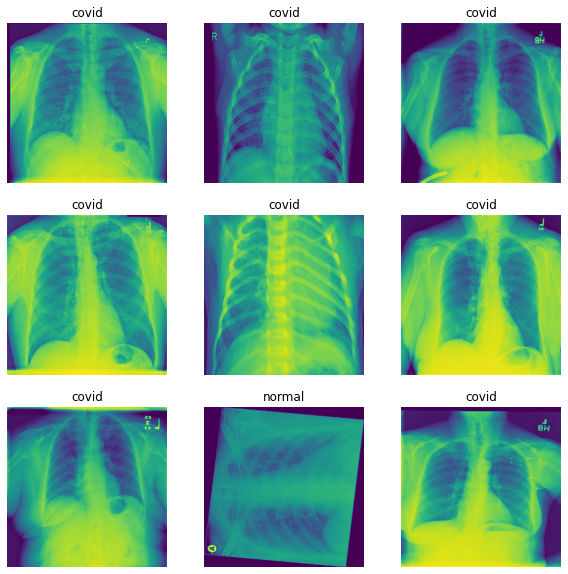

In [ ]:
### check if the data batches work properly or not 

plt.figure(figsize=(10, 10))
for images, labels in train_data_batches.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
        #plt.title(class_names[labels[i]])
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
        plt.axis("off")

In [ ]:
## This cell was used to compile the baseline model
### Cosine Decay was tested

class customCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.epoch = epoch + 1
    if self.epoch % 2 == 0:
      print (
          'epoch num {}, train loss: {}, validation loss: {}'.format(epoch, logs['loss'], logs['val_loss']))

reduce_lr = ReduceLROnPlateau(monitor='val_loss',  factor=0.2, patience=3, min_lr=1e-8, verbose=1)



# mcp_save = ModelCheckpoint(filepath="best_model_weights.h5",
#                            save_best_only=True, save_weights_only=True, monitor='val_loss')



## added after saving the best model  via val loss gives worse performance than the final step of the model 

mcp_save = ModelCheckpoint(filepath="best_model_weights.h5",
                           save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')



##restore best weights added after 2nd training
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)


### added after 2nd training 

METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

In [ ]:
freq_0 = tot_normal_train/(tot_normal_train + tot_pneumonia_train+tot_covid_train)
freq_1 = tot_pneumonia_train/(tot_normal_train + tot_pneumonia_train+tot_covid_train)
freq_2 = tot_covid_train/(tot_normal_train + tot_pneumonia_train+tot_covid_train)

weights_0 = np.array([freq_1])
weights_1 = np.array([freq_0])
weights_2 = np.array([freq_2])

print ('check covid weight: ', weights_2, len(weights_2))
print ('check pneumonia weight: ', weights_1, len(weights_1))
print ('check normal weight: ', weights_0)


def get_weighted_loss(weights_0, weights_1,weights_2, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0

        for i in range(len(weights_2)): # we have only 1 class 
            # for each class, add average weighted loss for that class 
            loss += - (K.mean((weights_2[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon)) + 
                              (weights_2[i] * (1-y_true[:, i]) * K.log(1-y_pred[:, i] + epsilon)) ) )
        return loss
    return weighted_loss

check covid weight:  [0.33478735] 1
check pneumonia weight:  [0.33260632] 1
check normal weight:  [0.33260632]


In [ ]:
input_shape = (300, 300, 3)

inception_resnet_v2 = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape)

def build_model():
    inputs = Input((300, 300, 1))
    
    x = preprocess_input(inputs) # necessary as per keras documentation 
    x = layers.Lambda(rescale_layer)(x) # rescale incoming images
    x = layers.Lambda(standardize_layer)(x) # standardize incoming images
    # x = layers.Lambda(data_augmentation)(x) # data augmentation layers
    x = Conv2D(3, (3,3), padding='same')(x) 
    # this is to fool the network that instead of rgb image we passed grayscale image but still have shape 3 at last axis (none, x, x, 3). 
    
    
    
    ###### InceptionResNetV2 + Some Top Layers
    x = BatchNormalization()(x)
    x = inception_resnet_v2(x)

    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (1, 1), activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dropout(0.75)(x)

    x = Dense(256, activation=LeakyReLU())(x)
    x = Dropout(0.80)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(3, activation="sigmoid")(x)
    
    model = Model(inputs, outputs)
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
#                   loss="binary_crossentropy", 
#                   metrics=METRICS)
# added weighted cross entropy loss for the loss instead of 
# "binary_crossentropy"

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss='categorical_crossentropy', 
                 metrics=METRICS)



    
    return model

219070464/219055592 [==============================] - 5s 0us/step


In [ ]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 1)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 1)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 1)      0         
 a)                                                              
                                                                 
 lambda (Lambda)             (None, 300, 300, 1)       0         
                                                                 
 lambda_1 (Lambda)           (None, 300, 300, 1)       0         
                                                                 
 conv2d_203 (Conv2D)         (None, 300, 300, 3)       30    

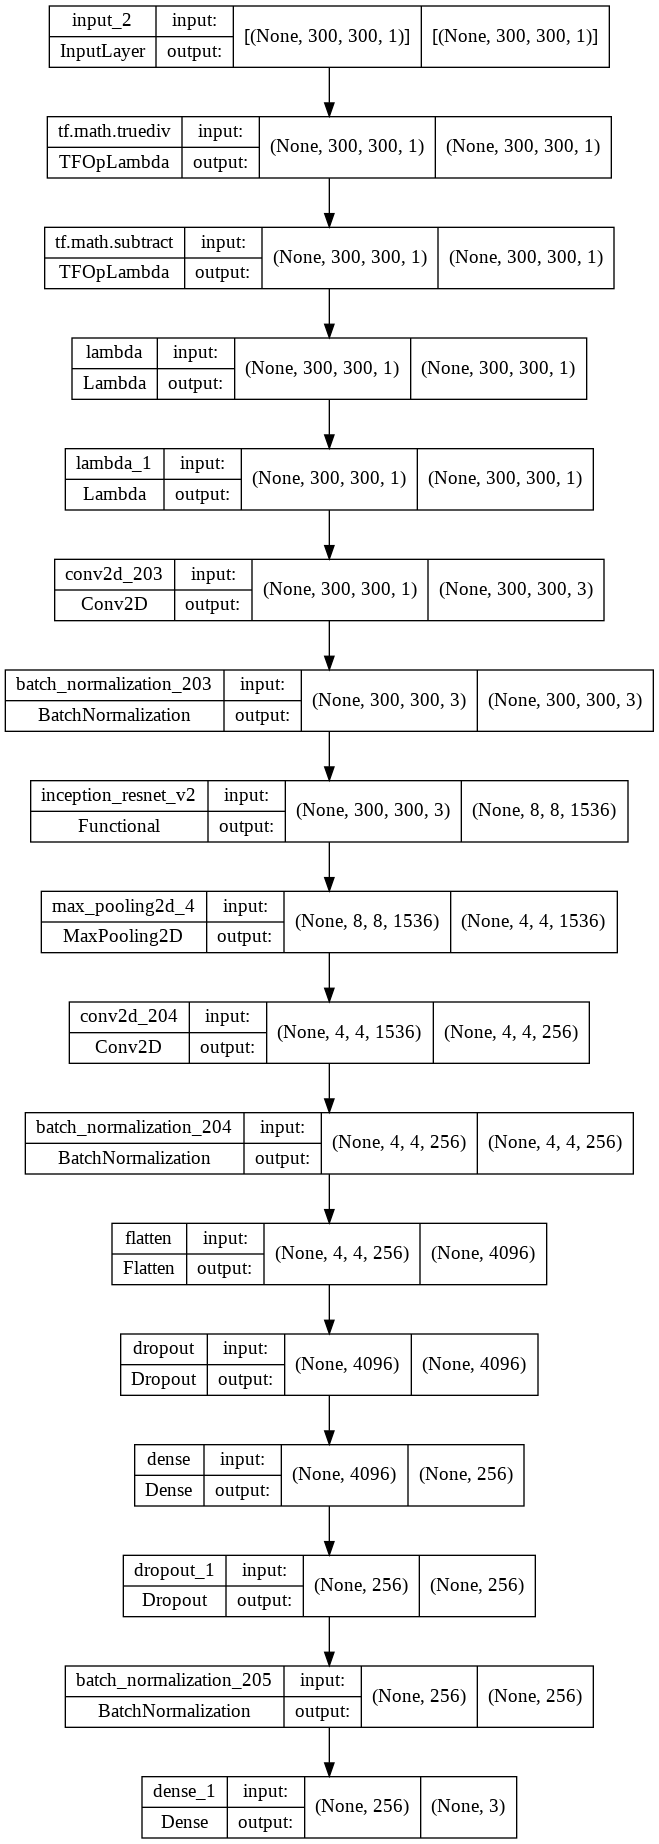

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import time
start_time = time.time()
history = model.fit(train_data_batches, 
                    epochs=25, 
                    validation_data=valid_data_batches,callbacks=[mcp_save, es, reduce_lr])

end_time = time.time()

Epoch 1/25
47/47 [==============================] - 111s 2s/step - loss: 0.6230 - accuracy: 0.7866 - precision: 0.6200 - recall: 0.8590 - prc: 0.8193 - val_loss: 2.7561 - val_accuracy: 0.3068 - val_precision: 0.4309 - val_recall: 0.2216 - val_prc: 0.4327 - lr: 0.0010
Epoch 2/25
47/47 [==============================] - 55s 1s/step - loss: 0.3569 - accuracy: 0.8916 - precision: 0.7211 - recall: 0.9282 - prc: 0.9247 - val_loss: 4.6126 - val_accuracy: 0.3466 - val_precision: 0.3609 - val_recall: 0.3722 - val_prc: 0.4083 - lr: 0.0010
Epoch 3/25
47/47 [==============================] - 55s 1s/step - loss: 0.2102 - accuracy: 0.9309 - precision: 0.7747 - recall: 0.9601 - prc: 0.9623 - val_loss: 7.7142 - val_accuracy: 0.3466 - val_precision: 0.3571 - val_recall: 0.3693 - val_prc: 0.3271 - lr: 0.0010
Epoch 4/25
47/47 [==============================] - 58s 1s/step - loss: 0.1573 - accuracy: 0.9475 - precision: 0.8078 - recall: 0.9754 - prc: 0.9754 - val_loss: 0.7024 - val_accuracy: 0.7869 - val_p

In [ ]:
print ('total time taken: in Minutes', (end_time-start_time)/60.)

total time taken: in Minutes 33.309803513685864


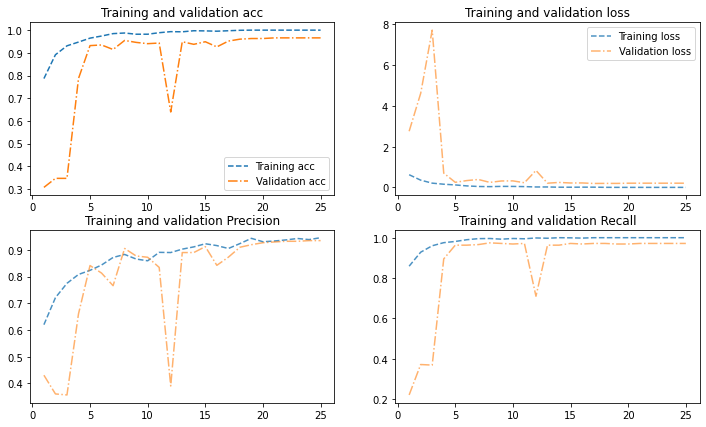

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']


epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(12, 7))
fig.add_subplot(221)

plt.plot(epochs, acc, linestyle='--', label = "Training acc")
plt.plot(epochs, val_acc, linestyle='-.', label = "Validation acc")
plt.title("Training and validation acc")
plt.legend()

fig.add_subplot(222)
plt.plot(epochs, loss, linestyle='--', label = "Training loss", alpha=0.8)
plt.plot(epochs, val_loss, linestyle='-.', label = "Validation loss", alpha=0.6)
plt.title("Training and validation loss")
plt.legend()

fig.add_subplot(223)
plt.plot(epochs, precision, linestyle='--', label = "Training Precision", alpha=0.8)
plt.plot(epochs, val_precision, linestyle='-.', label = "Validation Precision", alpha=0.6)
plt.title("Training and validation Precision")

fig.add_subplot(224)
plt.plot(epochs, recall, linestyle='--', label = "Training Recall", alpha=0.8)
plt.plot(epochs, val_recall, linestyle='-.', label = "Validation Recall", alpha=0.6)
plt.title("Training and validation Recall")

plt.show()

In [ ]:
test_dir = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/', 
                                                               image_size=target_size, 
                                                               batch_size=batch_size, 
                                                               color_mode='grayscale',
                                                               label_mode='categorical',
                                                               seed=1337)

Found 456 files belonging to 3 classes.


In [ ]:
test_data_batches = test_dir.cache().prefetch(buffer_size=autotune)

In [ ]:
model.evaluate(test_data_batches)

15/15 [==============================] - 8s 414ms/step - loss: 0.1159 - accuracy: 0.9759 - precision: 0.9393 - recall: 0.9846 - prc: 0.9911


[0.11592530459165573,
 0.9758771657943726,
 0.939330518245697,
 0.984649121761322,
 0.9911202192306519]

In [ ]:
#### check if the saved weights work fine or not 

model.load_weights("best_model_weights.h5")
model.evaluate(test_data_batches)

15/15 [==============================] - 5s 321ms/step - loss: 0.1004 - accuracy: 0.9693 - precision: 0.9451 - recall: 0.9825 - prc: 0.9915


[0.10038244724273682,
 0.969298243522644,
 0.945147693157196,
 0.9824561476707458,
 0.9915037751197815]

In [ ]:
y_pred = model.predict(test_data_batches)
print ('check y_pred: ', y_pred[0:10])

check y_pred:  [[0.0494376  0.00688454 0.99935216]
 [0.99997485 0.00379169 0.05113053]
 [0.01646577 0.01976803 0.99932325]
 [0.02507485 0.02654898 0.99866307]
 [0.02336698 0.04884358 0.9976121 ]
 [0.03289709 0.01590002 0.99898297]
 [0.10875288 0.03487576 0.99622476]
 [0.04416017 0.01774847 0.998804  ]
 [0.9989993  0.04387759 0.11246917]
 [0.55349076 0.8772481  0.11701117]]


In [ ]:
#### set a different threshold 

y_pred_th = (y_pred > 0.75).astype(np.float32)
#predicted_categories_th = tf.argmax(y_pred_th, axis=1)
#print ('check predicted catagories: ', predicted_categories_th[0:10])
print (y_pred_th[0:10])

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [ ]:
true_categories = tf.concat([y for x, y in test_data_batches], axis=0)
print ('check true catagories: ', true_categories[0:10])

check true catagories:  tf.Tensor(
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]], shape=(10, 3), dtype=float32)


In [ ]:
from sklearn.metrics import confusion_matrix
#print(confusion_matrix(test.classes, pred > 0.7))
#pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))
cm = confusion_matrix(np.asarray(true_categories).argmax(axis=1),np.asarray(y_pred_th).argmax(axis=1))

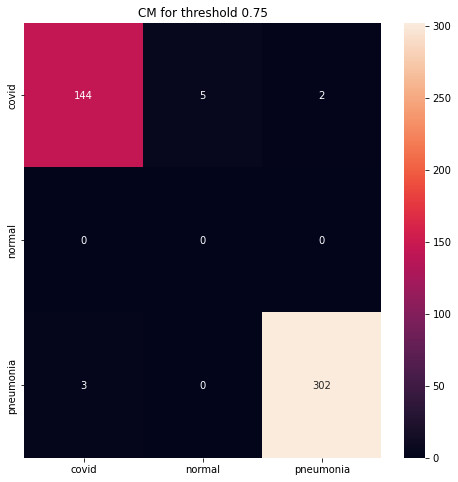

In [ ]:
plt.figure(figsize=(8,8))
plt.title('CM for threshold 0.75')
sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_names[i] for i in range(len(class_names))], 
                      yticklabels = [class_names[i] for i in range(len(class_names))], fmt="d")
fig = sns_hmp.get_figure()

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(true_categories, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ValueError: ignored

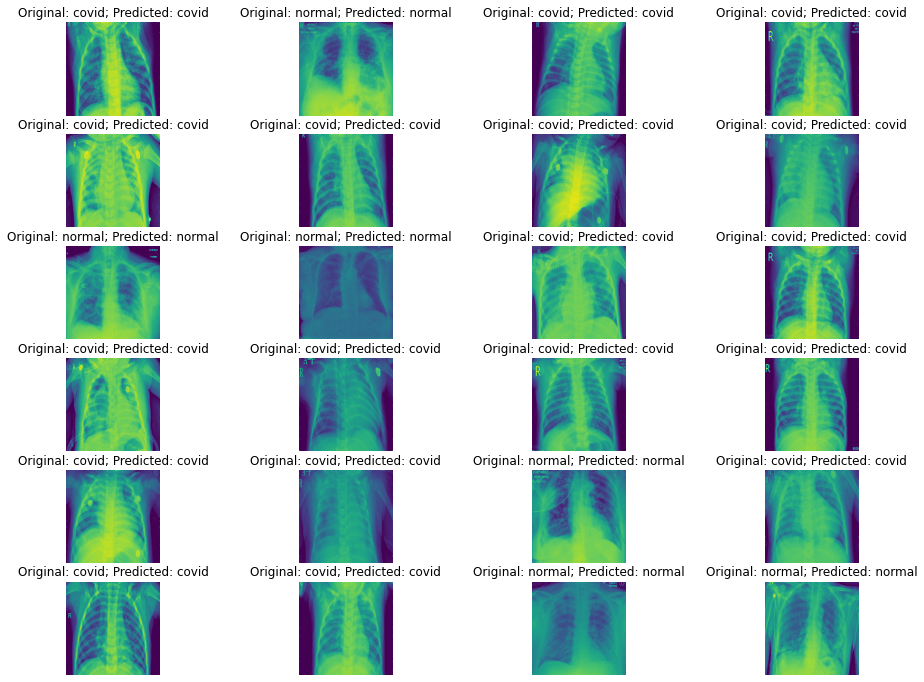

In [ ]:
plt.figure(figsize=(16, 12))
for images, labels in test_data_batches.take(1):
    for i in range(24):
        ax = plt.subplot(6, 4, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
        #plt.title(class_names[labels[i]])
        
        y_pred_batch = model.predict(tf.expand_dims(images[i], axis=0, ))
        y_pred_75th = (y_pred_batch > 0.75).astype(np.uint8)
        original_label = class_names[labels[i].numpy().astype("uint8")[0]]
        predicted_label = class_names[y_pred_75th[0].astype("uint8")[0]]
        plt.title(f'Original: {original_label}; Predicted: {predicted_label}')
        plt.axis("off") 

In [ ]:
import cv2
import os
import glob

for folder in ['covid', 'normal','pneumonia']:
  image_path = os.path.join(os.getcwd(), ('/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/' + folder))
  print(image_path)
  for file in glob.glob(image_path + '/*.jpg'):
    image = cv2.imread(file)
    file_type = imghdr.what(file)
    if file_type != 'jpeg':
      print(file + " - invalid - " + str(file_type))
# cv2.imwrite(file, image)

/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/covid
/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/normal
/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/pneumonia


In [ ]:
import cv2
import os
import glob

for folder in ['covid', 'normal','pneumonia']:
  image_path = os.path.join(os.getcwd(), ('/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/' + folder))
  print(image_path)
  for file in glob.glob(image_path + '/*.jpg'):
    image = cv2.imread(file)
    file_type = imghdr.what(file)
    if file_type != 'jpeg':
      print(file + " - invalid - " + str(file_type))
      os.remove(file)
# cv2.imwrite(file, image)

/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/covid
/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/covid/COVID19(326).jpg - invalid - png
/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/covid/COVID19(327).jpg - invalid - png
/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/covid/COVID19(323).jpg - invalid - png
/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/covid/COVID19(306).jpg - invalid - png
/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/covid/COVID19(304).jpg - invalid - png
/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/covid/COVID19(316).jpg - invalid - png
/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/covid/COVID19(298).jpg - invalid - png
/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/covid/COVID19(310).jpg - invalid - png
/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/covid/COVID19(324).jpg - invalid - png
/content/drive/My Drive/Colab Not

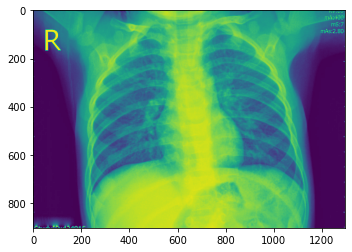

In [ ]:
img_path = "/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/pneumonia/person1353_bacteria_3446.jpg"
img=plt.imread(img_path)
plt.imshow(img)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
img = image.load_img(img_path, target_size=(300, 300))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
print(img_preprocessed.shape)

(1, 300, 300, 3)


In [ ]:
prediction = model.predict(img_preprocessed)

In [ ]:
print(prediction)

[[0.00716074 0.04965154 0.9990619 ]]


In [ ]:
print(class_names)

['covid', 'normal', 'pneumonia']
